In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import inspect
import os
import sys
import time

import paragami

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
reg_params = dict()
#datafile = 'fits/transformed_gene_regression_df7_degree3_genes10000.npz'
datafile = 'fits/transformed_gene_regression_df7_degree3_genes1000.npz'
with np.load(datafile) as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    df = infile['df']
    degree = infile['degree']
    
num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

num_components = 100

analysis_name = 'transformed_gene_regression_df{}_degree{}_genes{}_num_components{}_fit'.format(
    df, degree, num_genes, num_components)
print(reg_params['beta_info'].shape, reg_params['beta_mean'].shape)

(700, 9, 9) (700, 9)


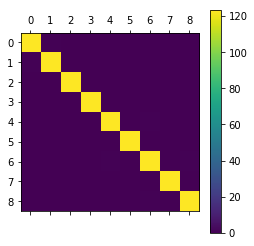

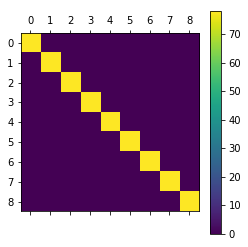

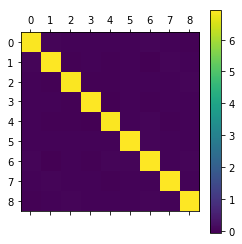

In [3]:
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
prior_params_pattern = gmm_lib.get_prior_params_pattern(obs_dim, num_components)
prior_params_pattern.validate_folded(prior_params)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [4]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [5]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -109322.70205104
Iter 1: f = -110407.24181743
Iter 2: f = -111877.61923141
Iter 3: f = -113093.98707787
Iter 4: f = -113531.70093881
Iter 5: f = -114231.75888387
Iter 6: f = -114493.45038505
Iter 7: f = -114856.65353999
Iter 8: f = -115205.29535984
Iter 9: f = -115314.54645663
Iter 10: f = -115619.69787889
Iter 11: f = -115867.98609023
Iter 12: f = -116025.85720673
Iter 13: f = -116181.79316348
Iter 14: f = -116288.54543880
Iter 15: f = -116282.13447741
Iter 16: f = -116358.57730746
Iter 17: f = -116406.20008357
Iter 18: f = -116467.70514043
Iter 19: f = -116526.33033394
Iter 20: f = -116572.37638708
Iter 21: f = -116636.68194363
Iter 22: f = -116714.78971517
Iter 23: f = -116461.27723878
Iter 24: f = -116761.54923531
Iter 25: f = -116810.45314627
Iter 26: f = -116888.68881548
Iter 27: f = -116899.42435298
Iter 28: f = -116923.32443193
Iter 29: f = -116948.22375786
Iter 30: f = -116927.65366469
Iter 31: f = -116971.14204800
Iter 32: f = -117012.57807644
Iter 33: f = -117080

In [6]:
tic = time.time()
# Note that h_cond is the Hessian.
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

In [7]:
h_cond.shape, gmm.kl_obj.grad(init_x2).shape
#np.linalg.solve(h_cond, gmm.kl_obj.grad(init_x2))

((1098, 1098), (1098,))

In [8]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True, kl_hess=h_cond)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Iter 0: f = -117547.24432536
Preconditioned iteration 1
  Taking Newton step.
(1098, 1098)
(1098,)
Iter 1: f = -117547.24432536
Iter 2: f = -117547.24432597
6.170739652588964e-07
Iter 3: f = -117547.24432597
Success.
  Running preconditioned optimization.
Iter 0: f = -117547.24432597
Iter 1: f = -117547.24432597
Iter 4: f = -117547.24432597
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Taking Newton step.
(1098, 1098)
(1098,)
  Converging with small Newton step.
Optimization time: 826.4738776683807 seconds


In [12]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.sort(np.sum(e_z, axis=0)))

odict_keys(['centroids', 'stick_propn_mean', 'stick_propn_info'])
[ 0.58333921  0.92746007  0.9864357   0.99922343  0.99967411  1.
  1.          1.00000019  1.00000049  1.00000066  1.00000084  1.00000155
  1.00006284  1.00077763  1.00210169  1.00371488  1.010889    1.01835276
  1.02450371  1.03300801  1.03404482  1.08469695  1.30457557  1.84206056
  1.99999277  2.000001    2.00005917  2.00016339  2.00637702  2.00935758
  2.06734584  2.08238035  2.10514196  2.13295346  2.14160085  2.19118274
  2.28686045  2.96690815  2.98941328  2.99039993  2.99965597  3.02887247
  3.04267492  3.09048013  3.28925273  3.90177106  3.99761527  3.99986681
  4.08917855  4.24094103  4.41154741  4.98979922  4.99593975  4.99975703
  5.00199721  5.01020718  5.02908223  5.43962645  5.84875085  6.0018556
  6.07542104  6.60976677  6.65003127  6.7032375   6.78568083  6.90569148
  7.21415452  7.31998949  7.32247838  7.47765834  8.52946355  8.58381472
  8.71916594  9.00000156  9.00006467  9.00035448  9.42880348  9.957

In [48]:
loglik_obs_by_nk = gmm_lib.get_loglik_obs_by_nk(opt_gmm_params, gmm.reg_params)

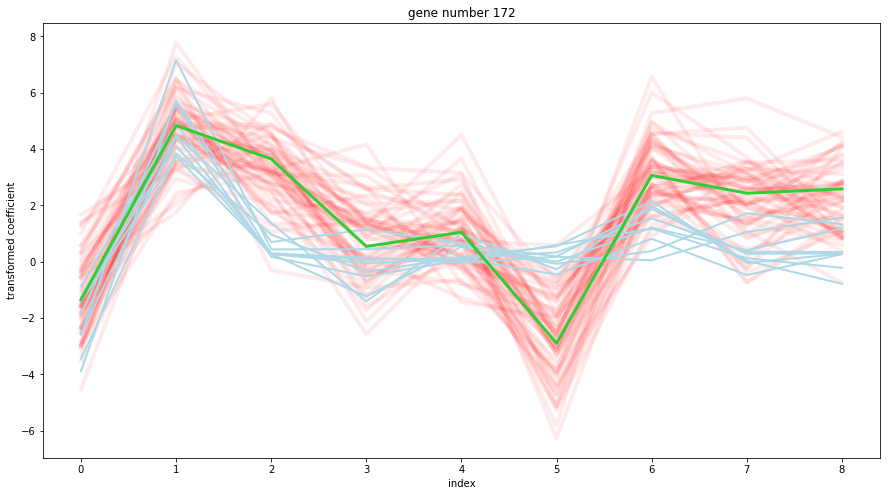

In [57]:
# for i in range(num_components):
#     print('{:0.5}\t{:0.5}'.format(np.sum(e_z, axis=0)[i], np.std(e_z, axis=0)[i]))

z_sum = np.sum(e_z, axis=0)
small_clusters = np.squeeze(np.argwhere(z_sum < 1.1))
small_clusters
obs_k = np.full(gmm.num_obs, int(-1))
for n in range(gmm.num_obs):
    obs_k[n] = np.argmax(e_z[n, :])

# Plot one of the small components
k_small = 2
n = int(np.argwhere(obs_k == small_clusters[k_small]))

# Get the top alternative components
top_components = np.argsort(-1 * loglik_obs_by_nk[n, :])[1:10]

f, axarr = plt.subplots(1, figsize=(15,8))
this_plot = axarr
this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
this_plot.set_ylabel('transformed coefficient')
this_plot.set_xlabel('index')
this_plot.set_title('gene number {}'.format(n))

# draw from the variational distribution to plot uncertainties
for j in range(60): 
    transformed_beta_draw = np.random.multivariate_normal(
        gmm.reg_params['beta_mean'][n, :], \
         np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))
    this_plot.plot(
        transformed_beta_draw, color = 'red', alpha = 0.08, linewidth=4);

for k in top_components:
    if k != k_small:
        this_plot.plot(opt_gmm_params['centroids'][k, :],
                       color = 'lightblue', linewidth=2);

k = np.argmax(e_z[n, :])
this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);


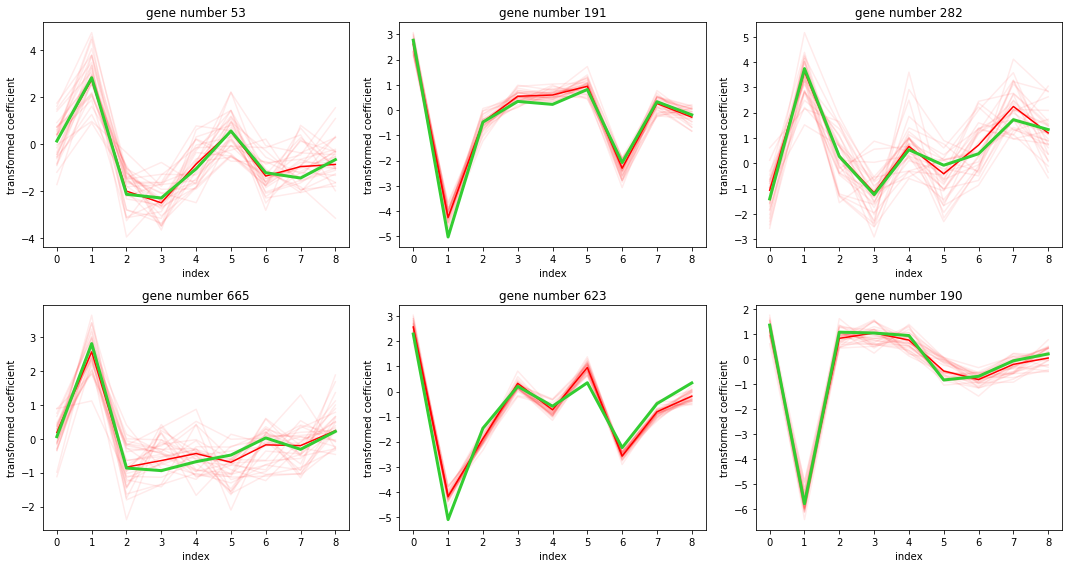

In [42]:
# Sanity check with a figure

f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()

In [11]:
save_dict = deepcopy(gmm_opt)
save_dict['df'] = df
save_dict['degree'] = degree
save_dict['datafile'] = datafile
save_dict['num_components'] = num_components
save_dict['gmm_params_pattern_json'] = \
    gmm.gmm_params_pattern.to_json()
save_dict['opt_gmm_params_flat'] = \
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=False)
save_dict['prior_params_pattern_json'] = \
    prior_params_pattern.to_json()
save_dict['prior_params_flat'] = \
    prior_params_pattern.flatten(prior_params, free=False)

save_dict['opt_time'] = opt_time

outfile = './fits/{}.npz'.format(analysis_name)
print('Saving to {}'.format(outfile))

np.savez_compressed(file=outfile, **save_dict)

Saving to ./fits/transformed_gene_regression_df7_degree3_genes700_num_components100_fit.npz
